# Auto-Regressive Integrated Average Model - ARIMA

Lecture Notebook
Prepared by: Matthew R. Maulion, MSc

Resources: 
- UDEMY, Applied Time Series Analysis
- Machine Learing Mastery, Jason Brown Lee

## Introduction to ARIMA

We have learned so far about the AR (p) model, MA (q) model, and other basic models when it comes to time series forecasting. What if there s a model that would integrate the models we have learned so far and make bettter and more accurate predictons? Welcome to a lecture in ARIMA **(Auto Regressive Integrated Moving Average Model).**

ARIMA is a popular and widely used statistical method for time series forecasting. It is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

For this lesson, you will discover how to develop an ARIMA model for time series forecasting in Python.

You will specifically know the following:

- About the ARIMA model the parameters used and assumptions made by the model.
- How to fit an ARIMA model to data and use it to make forecasts.
- How to configure the ARIMA model on your time series problem.

## What is ARIMA?

As discussed above, an ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration which basically is the data transformation we have been doing in the past weeks - **differencing**.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR: Autoregression. (p)** A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I: Integrated. (d)** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA: Moving Average. (q)** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with **integer values to quickly indicate the specific ARIMA model being used**.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. Because again, a requirement in time series forecasting is to make sure that the data is stationary. _(Recall topic in AR, MA and ARMA models)_

Note that when you place integer values on the parameter list of an ARIMA model:

- A value of 0 can be used for a parameter, which indicates to not use that element of the model. 
- Meaning, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model respectively.

Always remember that adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

Mathematically, the ARIMA(p,d,q) model is represented as follows:

<img src='../data/external/images/arima.PNG' width=800 height=200 />

where, again:
- p: The number or order of lag observations included in the model, also called the lag order.
- d: The number of times or the degree that the raw observations are differenced, also called the degree of differencing.
- q: The size or order of the moving average window, also called the order of moving average.


## Implementation of the ARIMA model

#### Importing important libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

### Diagnosing the Dataset

The dataset we have is the same dataset we worked with the AR (p) and MA (q) lecture. This is the Quarterly Earnings per Share for Johnson&Johnson (J&J). 

In [19]:
data = pd.read_csv('jj.csv')
data.head() #looking at some datapoints of the csv

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


#### Visualizing the Dataset

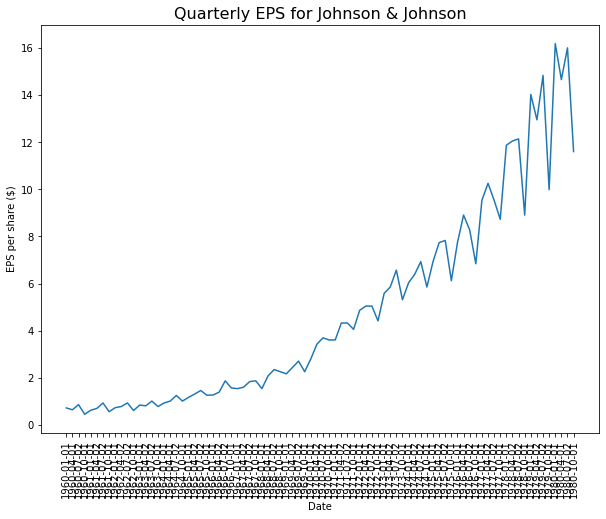

In [20]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson', size = 16)
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

#### Plotting the ACF and PACF of the Dataset

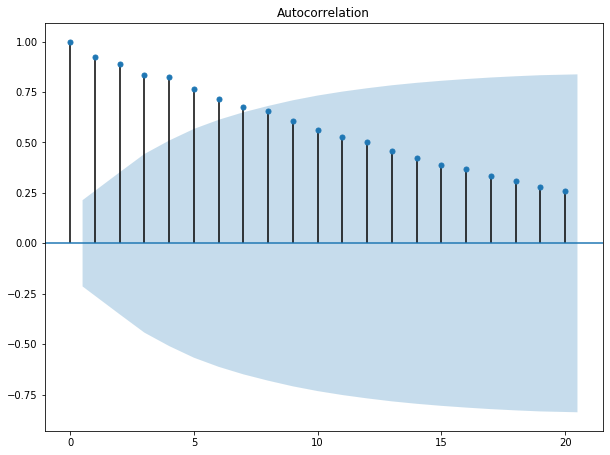

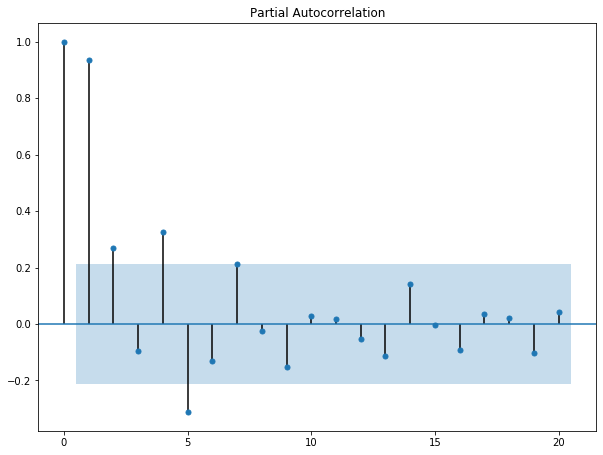

In [5]:
plot_acf(data['data']);
plot_pacf(data['data']);

Review: Why do we need to plot the ACF and PACF of our time series data? 

As a preliminary step, the ACF will tell us if our data stationary or non-stationary. If it is the latter, then we need to apply data transforamtions and that is what we call differencing. 

#### Checking for stationarity using adfuller test

In [6]:
ad_fuller_result = adfuller(data['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457473
p-value: 1.0


Given a high ad-fuller score, the dataset is indeed non-stationary which needs differencing. 

#### Differencing using Log differencing

In [7]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


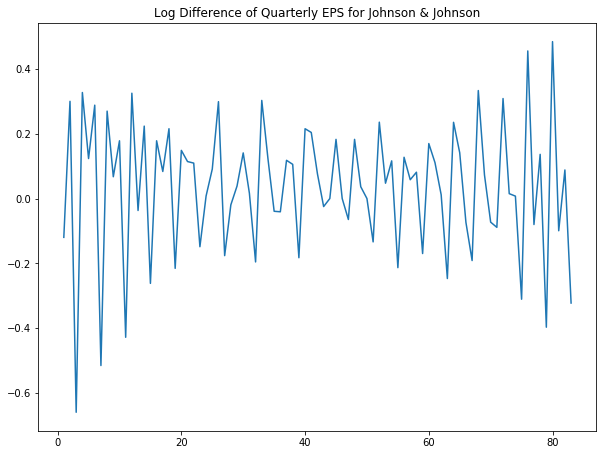

In [8]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

As we can see, the variance of our dataset looks stable and no evident seasons and trends can be observed. Hence, we are successful in differencing. 

#### Checking for stationarity using adfuller test

In [9]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811827
p-value: 0.0004149731404440817


Since the p-value is less than 0.05, we can say that indeed our dataset is now stationary and ready for modeling.

#### Plotting the ACF and PACF of the Dataset

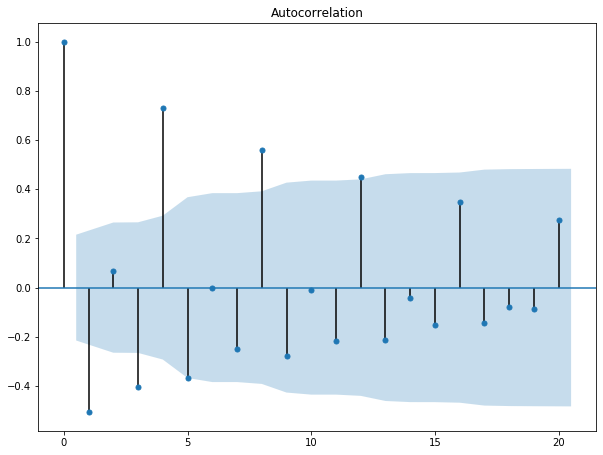

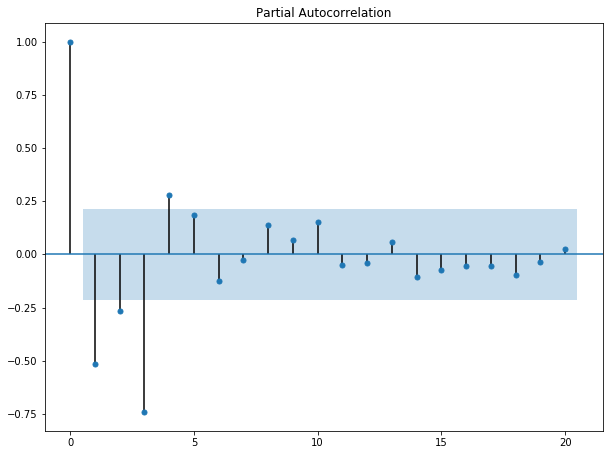

In [10]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);

However, when we view the ACF and PACF plot, there is no clear cut order that we can choose because both exhibit sinusoidal behavior which blurs our understanding in choosing the appropriate order of for AR (p) and MA (q). Therefore, it conclusive to say that generating ACF and PACF plots would be less contributing in ARIMA analysis. 

## How do we then do ARIMA Modeling?

### The Akakie's Information Criterion

Since ACF and PACF pots bear little information in doing ARIMA analysis, we will evaluate a set of orders and pick the best one using a criteria. This crietria is named the Akakie's Information Criterion (AIC)  

- It is used to select the best order (p,q) of an AR(p) and MA(q) model
 
The mathematical explanation for AIC is presented below: 

<img src='../data/external/images/aic.PNG' width=400 height=100 />

where
- L : Likelihood of the data
- k L number of parameters

#### What AIC to choose the best model?

- Select the model with the **lowest AIC** compared to other models 

**Assumption in using AIC**

- Note that the AIC cannot be used to selEct the Order of differencing (d) becuase it will change the likelihood (L). Hence, we can only compare AIC with a constant differencing value (d) in ARIMA analysis. 

### Finding the optimal ARIMA Model

We will be creating a function that will give us the best ARIMA model from a set of pre-defined orders for p, d, and q. We will name this function `optimize_ARIMA`. 

Look at how the function works below: 

In [22]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    #list that will contain the results of every ARIMA model (p,d,q)
    results = []
    
    #tqdm is a timer and progress bar (for any programmer's sanity)
    #this loop will create the 
    for order in tqdm_notebook(order_list):
        
        # will create a model based on provided `order_list`
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        
        #will just continue if it encounters an error (a try clause is always paired with except)
        except:
            continue
        
        #calculates the aic value of the model
        aic = model.aic
        
        #appends a list containing the order with its respective aic value
        results.append([order, aic])
    
    #converts the `results` list into a dataframe
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    #returns the summary df containing all the salient information
    return result_df

#### Setting up the set of values to consider for `optimize_ARIMA`

In [36]:
list(range(0, 8, 1))

[0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
list(range(0, 15, 1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [33]:
# list(parameters_list)

In [34]:
#p values to test
ps = range(0, 8, 1)

#constant differencing value d
d = 1

#q values to test
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs) #the product function will create all possible combinations of p and q to evaluate
parameters_list = list(parameters)

#save the combinations in an empty list
order_list = []

#create a tuple for each possible combinationn and insert the constant differencing value d = 1
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

#display the first ten values in the order list
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [35]:
len(order_list)

64

#### Running the Function

You will see a progress bar below to let know what iteration it is currently running in the for loop in the function.

In [38]:
data['data']

0      0.71
1      0.63
2      0.85
3      0.44
4      0.61
      ...  
79     9.99
80    16.20
81    14.67
82    16.02
83    11.61
Name: data, Length: 84, dtype: float64

In [39]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.299316
1,"(4, 1, 6)",115.859200
2,"(7, 1, 1)",116.050829
3,"(5, 1, 3)",116.534546
4,"(5, 1, 4)",117.243594
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


#### Creating your Optimal ARIMA Model

Again, the best model will be one with the lowest AIC score. Use the parameters of the model in creating your optimal model below:

In [40]:
best_model = SARIMAX(data['data'], order=(6,1,3), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.650
Date:                Wed, 24 Nov 2021   AIC                            115.299
Time:                        11:13:21   BIC                            139.488
Sample:                             0   HQIC                           125.017
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4685      0.121    -12.112      0.000      -1.706      -1.231
ar.L2         -0.7627      0.144     -5.309      0.000      -1.044      -0.481
ar.L3          0.0436      0.062      0.705      0.4

There are evident variables that are not significant and we can do away with them moving forward. 

#### Model Diagnostics (Residual Report)

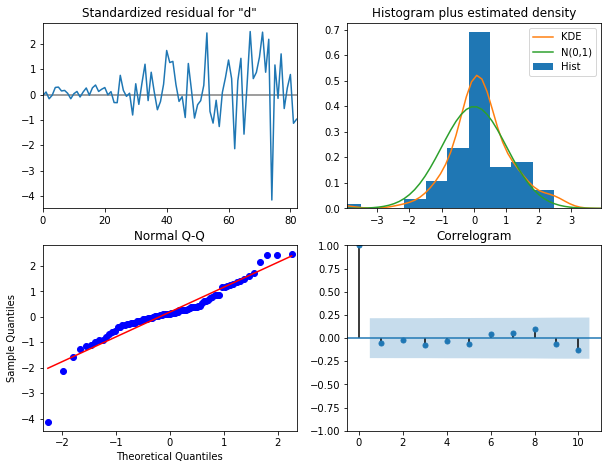

In [15]:
res.plot_diagnostics();

As can be observed, the histogram and qq-plot is telling us that our residuals approaching a normal distrbution which is the desired behavior in a time series analysis. Therefore, we can now move forward in making our predictions. 

## Making our Predictions

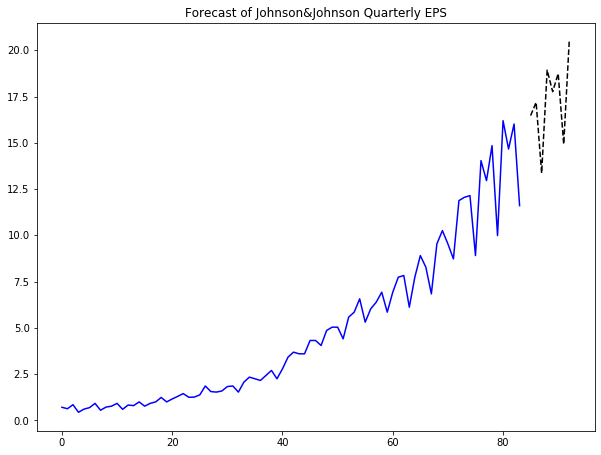

In [41]:
n_forecast = 8 #Lets say we want to forecast 8 quarters of data in the future
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

#visualize the predictions with respect ot historical data (use different markers)
fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()

### Making the dataframe of predictions

In [44]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,model
0,1960-01-01,0.71,0.000000
1,1960-04-01,0.63,0.709998
2,1960-07-02,0.85,0.680984
3,1960-10-01,0.44,0.720405
4,1961-01-01,0.61,0.650954
5,1961-04-02,0.69,0.527131
6,1961-07-02,0.92,0.788450
7,1961-10-01,0.55,0.487756
8,1962-01-01,0.72,0.650407
9,1962-04-02,0.77,0.750676


### Evaluating the model using MSE

In [43]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.15995720581725137


Again, in time series analysis, the lower the error values the better the model. And a metric that will be used should be relevant and appropriate to the study at hand. 

## Individual Assignment: 

Document your code properly and satisfy the following conditions:

1. Create an ARIMA model in predicting the **Monthly Mean Total Sunspot Number** from the `Sunspots.csv` dataset provided in this same repository. 
2. Just use the most recent 5 years of data. 
3. Find the optimal ARIMA model from the following set of p, d, q values: 
> p: from 0 to 10 <br>
> d: d = 1 <br>
> q: from 0 to 10

4. Predict the next 2 years of data (24 months). Plot the predictions together with the historical data
5. Evaluate the performance of the model using RMSE. 